In [1]:
# Pacotes utilizados
using PyPlot
using LinearAlgebra
using Random
using Statistics
using Printf
using JLD2, FileIO
using ProgressMeter
include("ILearning.jl")
rng = MersenneTwister(1234);

In [2]:
function Correlation(U,alpha=1,Win = nothing)
    
    row, col = size(U)
    
    if Win==nothing
        W = zeros(Complex, row,row)
    else
        W = copy(Win)
    end
    
    for i=1:col
        W += alpha*(U[:,i]*U[:,i]')
    end    
    return W 
end


function Projection(U, Win = nothing, Ain = nothing)
    
   row, col = size(U)
        
   if Win == nothing
        W = zeros(Complex, row,row);
        A = I(row)
   else
        W = copy(Win)
        A = copy(Ain)
   end
        
   for i=1:col
       z = A*U[:,i];
       zz = real(z'*z)
       if zz>1.e-7
           A = A - (z*z')/zz;
           v = W*U[:,i]
           W += (U[:,i]-v)*(z'/zz);
       end
   end
   return W, A
end

Projection (generic function with 3 methods)

In [3]:
function Storkey1(U,alpha,Win=nothing)
    row, col = size(U)
    if Win==nothing
        W = zeros(Complex, row,row)
    else
        W = copy(Win)
    end
    
    for i = 1:col
        u = U[:,i]
        h = W*u
        W += alpha*(u*u' - u*h' - h*u')
    end
    return W
end
    
function Storkey2(U,alpha,Win=nothing)
    row, col = size(U)
    if Win==nothing
        W = zeros(Complex, row,row)
    else
        W = copy(Win)
    end
    
    for i = 1:col
        u = U[:,i]
        h = W*u
        W += alpha*((u-h)*(u-h)')
#         println(norm(W))
    end
    return W
end

Storkey2 (generic function with 2 methods)

In [4]:
N = 100;

### Number of Simulations
Nsim = 300

## Noise
Npr = 51
pr = range(0,1,length = Npr);

Pv = [10,20,30,40];

In [5]:
### Number of maximum iterations for the HNN model
it_max = 1000

# Learning step
alpha = 1/(2*N)

### Estados Possiveis
MultiStates = [1.0 + 1.0im, 1.0 - 1.0im, -1.0 + 1.0im, -1.0 - 1.0im]

4-element Array{Complex{Float64},1}:
  1.0 + 1.0im
  1.0 - 1.0im
 -1.0 + 1.0im
 -1.0 - 1.0im

In [6]:
Success = zeros(Int64,(4,Npr,4));

@showprogress for s = 1:Nsim
    for k = 1:4
        # Generate the fundamental memories;
        U = rand(rng,MultiStates,(N,Pv[k]))
        
        # Learning rules;
        W = [zeros(Complex,N,N) for i=1:4];
        W[1]= Storkey1(U,alpha);
        W[2] = Storkey2(U,alpha)
        W[3] = Correlation(U,alpha);
        W[4], A = Projection(U);
        # Remove the diagonal
        for i=1:4
            W[i] = W[i] - Diagonal(Diagonal(W[i]))
        end
        
        # For each noise probability;
        for j=1:Npr
            # Pick the index of a fundamental memory;
            xi = rand(rng,1:Pv[k]);
            
            # Introduce noise into a fundamental memory;
            x0 = ILearning.noise(U[:,xi],MultiStates,pr[j]);
            
            for i=1:4
                y = ILearning.Asy(W[i],x0,ILearning.splitsign,nothing,it_max)
                Error = sum(abs.(U[:,xi]-y))
            
                if Error<1.e-4
                    Success[i,j,k] += 1
                end
            end
        end
    end
    @save "JLDs/NoiseTolerance_SplitSign.jld2" Success Pv pr
end

Progress: 100%|█████████████████████████████████████████| Time: 0:19:38


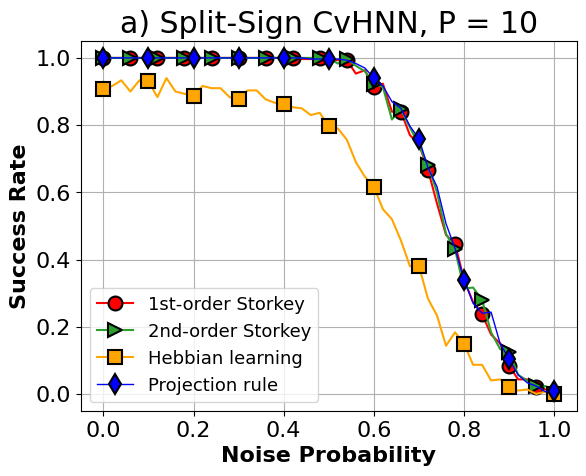

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [7]:
@load "JLDs/NoiseTolerance_SplitSign.jld2"

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
font0 = Dict(
        "font.size" => 18,
        "axes.labelweight" => "bold",
        "axes.labelsize" => 16,
        "xtick.labelsize" => 16,
        "ytick.labelsize" => 16,
        "legend.fontsize" => 13,
)
merge!(rcParams, font0)
plot(pr,Success[1,:,1]/Nsim,linewidth=1.5,color="red",linestyle ="solid", marker="o",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "1st-order Storkey")

plot(pr,Success[2,:,1]/Nsim,color="#2ca02c",linestyle ="solid", marker=">",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "2nd-order Storkey")

plot(pr,Success[3,:,1]/Nsim,color="orange",linestyle ="solid", marker="s",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "Hebbian learning")

plot(pr,Success[4,:,1]/Nsim,linewidth=1,color="blue",linestyle ="solid",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0), marker="d",label = "Projection rule")

legend()
grid()

xlabel("Noise Probability")
ylabel("Success Rate")
title("a) Split-Sign CvHNN, P = 10")

savefig("Figures/NoiseTolerance_SplitSign_10.eps",bbox_inches="tight")
savefig("Figures/NoiseTolerance_SplitSign_10.pdf",bbox_inches="tight")

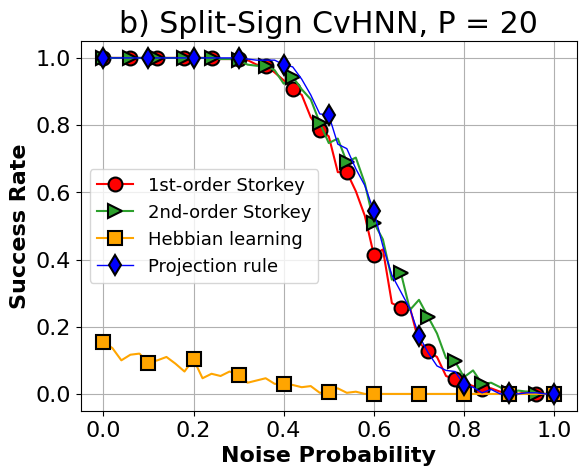

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [8]:
@load "JLDs/NoiseTolerance_SplitSign.jld2"

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
font0 = Dict(
        "font.size" => 18,
        "axes.labelweight" => "bold",
        "axes.labelsize" => 16,
        "xtick.labelsize" => 16,
        "ytick.labelsize" => 16,
        "legend.fontsize" => 13,
)
merge!(rcParams, font0)
plot(pr,Success[1,:,2]/Nsim,linewidth=1.5,color="red",linestyle ="solid", marker="o",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "1st-order Storkey")

plot(pr,Success[2,:,2]/Nsim,color="#2ca02c",linestyle ="solid", marker=">",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "2nd-order Storkey")

plot(pr,Success[3,:,2]/Nsim,color="orange",linestyle ="solid", marker="s",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "Hebbian learning")

plot(pr,Success[4,:,2]/Nsim,linewidth=1,color="blue",linestyle ="solid",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0), marker="d",label = "Projection rule")

legend()
grid()

xlabel("Noise Probability")
ylabel("Success Rate")
title("b) Split-Sign CvHNN, P = 20")

savefig("Figures/NoiseTolerance_SplitSign_20.eps",bbox_inches="tight")
savefig("Figures/NoiseTolerance_SplitSign_20.pdf",bbox_inches="tight")

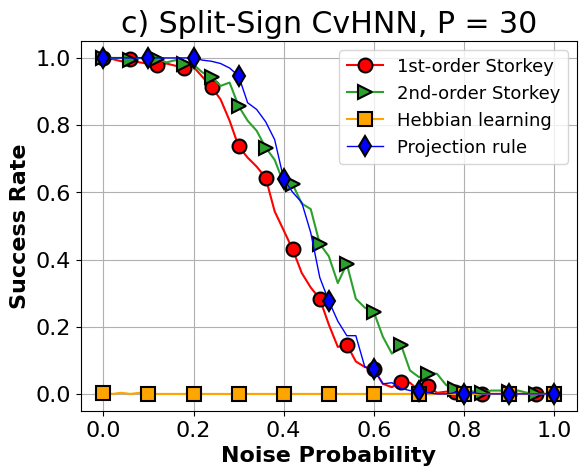

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [9]:
@load "JLDs/NoiseTolerance_SplitSign.jld2"

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
font0 = Dict(
        "font.size" => 18,
        "axes.labelweight" => "bold",
        "axes.labelsize" => 16,
        "xtick.labelsize" => 16,
        "ytick.labelsize" => 16,
        "legend.fontsize" => 13,
)
merge!(rcParams, font0)
plot(pr,Success[1,:,3]/Nsim,linewidth=1.5,color="red",linestyle ="solid", marker="o",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "1st-order Storkey")

plot(pr,Success[2,:,3]/Nsim,color="#2ca02c",linestyle ="solid", marker=">",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "2nd-order Storkey")

plot(pr,Success[3,:,3]/Nsim,color="orange",linestyle ="solid", marker="s",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "Hebbian learning")

plot(pr,Success[4,:,3]/Nsim,linewidth=1,color="blue",linestyle ="solid",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0), marker="d",label = "Projection rule")

legend()
grid()

xlabel("Noise Probability")
ylabel("Success Rate")
title("c) Split-Sign CvHNN, P = 30")

savefig("Figures/NoiseTolerance_SplitSign_30.eps",bbox_inches="tight")
savefig("Figures/NoiseTolerance_SplitSign_30.pdf",bbox_inches="tight")

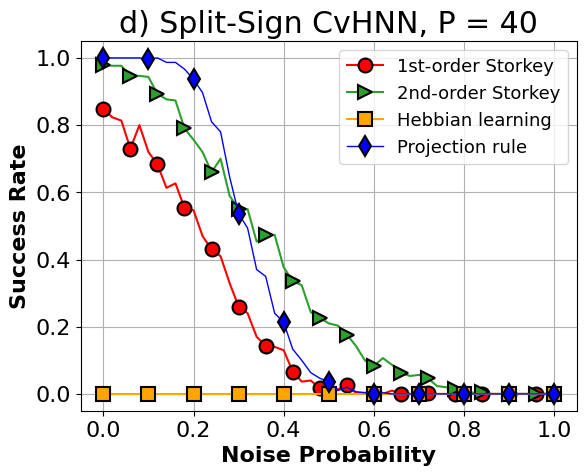

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [10]:
@load "JLDs/NoiseTolerance_SplitSign.jld2"

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
font0 = Dict(
        "font.size" => 18,
        "axes.labelweight" => "bold",
        "axes.labelsize" => 16,
        "xtick.labelsize" => 16,
        "ytick.labelsize" => 16,
        "legend.fontsize" => 13,
)
merge!(rcParams, font0)
plot(pr,Success[1,:,4]/Nsim,linewidth=1.5,color="red",linestyle ="solid", marker="o",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "1st-order Storkey")

plot(pr,Success[2,:,4]/Nsim,color="#2ca02c",linestyle ="solid", marker=">",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "2nd-order Storkey")

plot(pr,Success[3,:,4]/Nsim,color="orange",linestyle ="solid", marker="s",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "Hebbian learning")

plot(pr,Success[4,:,4]/Nsim,linewidth=1,color="blue",linestyle ="solid",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0), marker="d",label = "Projection rule")

legend()
grid()

xlabel("Noise Probability")
ylabel("Success Rate")
title("d) Split-Sign CvHNN, P = 40")

savefig("Figures/NoiseTolerance_SplitSign_40.eps",bbox_inches="tight")
savefig("Figures/NoiseTolerance_SplitSign_40.pdf",bbox_inches="tight")